# [Two Sigma Financial Modelling Challenge](https://www.kaggle.com/c/two-sigma-financial-modeling)
Can you uncover predictive value in an uncertain world? Hosted by [Kaggle](https://www.kaggle.com)

In [1]:
'''Here are all the modules we will be using in this notebook. Make sure you can import everything before moving on!'''

import numpy as np
import pandas as pd
import tensorflow as tf

import sys
import os
sys.path.append(os.path.abspath('./src'))
from model import *
from transformer import *
from observer import *
from evaluation import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

data_root = './data/'

__dyn_plot__ helps visualize the learning process dynamically. For details, read the answer by [HYRY](http://stackoverflow.com/users/772649/hyry):

* [how to dynamically update a plot in a loop in ipython notebook within one cell](http://stackoverflow.com/questions/21360361/how-to-dynamically-update-a-plot-in-a-loop-in-ipython-notebook-within-one-cell)

In [2]:
# def dyn_plot(history):
#     plt.clf()
#     plt.plot(history)
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

## Preprocess

We split the training data into training, validation and test sets holding pairwise disjoint timestamps.
These dataframes may share instruments.

In [3]:
# raw_df = pd.read_hdf(data_root + 'train.h5')

# num_time_stamps = len(raw_df['timestamp'].unique())
# valid_start_ind = int(num_time_stamps * 0.5)
# test_start_ind = int(num_time_stamps * 0.8)

# raw_train_df = raw_df[raw_df['timestamp'] < valid_start_ind]
# raw_valid_df = raw_df[(raw_df['timestamp'] < test_start_ind) & (raw_df['timestamp'] >= valid_start_ind)]
# raw_test_df = raw_df[(raw_df['timestamp'] <= test_start_ind)]

# raw_df = None # Release memory

In [4]:
# T = Transformer()
# T.fit(raw_train_df)

# train_df = T.transform(raw_train_df)
# raw_train_df = None # Release Memory
# print('processed training dataframe')

# valid_df = T.transform(raw_valid_df)
# raw_valid_df = None # Release Memory
# print('processed validation dataframe')

# test_df = T.transform(raw_test_df)
# raw_test_df = None # Release Memory
# print('processed test dataframe')

In [5]:
# train_df.to_hdf(data_root+'train_df.h5', key='train')
# valid_df.to_hdf(data_root+'valid_df.h5', key='valid')
# test_df.to_hdf(data_root+'test_df.h5', key='test')

## Train

In [6]:
train_df = pd.read_hdf(data_root+'train_df.h5', key='train')
ids = train_df['id'].unique()[:500]
train_df = train_df[train_df['id'].isin(ids)]

In [ ]:
# Params
num_epoch = 8
batch_size = 16
num_feat = 109
lstm_size = 128
fc_hidd_size = 64
lr = 1e-3

M = Model(num_feat=num_feat, lstm_size=lstm_size, fc_hidd_size=fc_hidd_size, lr=lr)
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
%%time

history = []
for e, b, loss in M.fit(session, train_df, num_epoch, batch_size):
    history.append(loss)
    if b == 0:
        print("e{}, b{}: {}".format(e, b, np.sqrt(loss)))

e0, b0: 0.475207364518


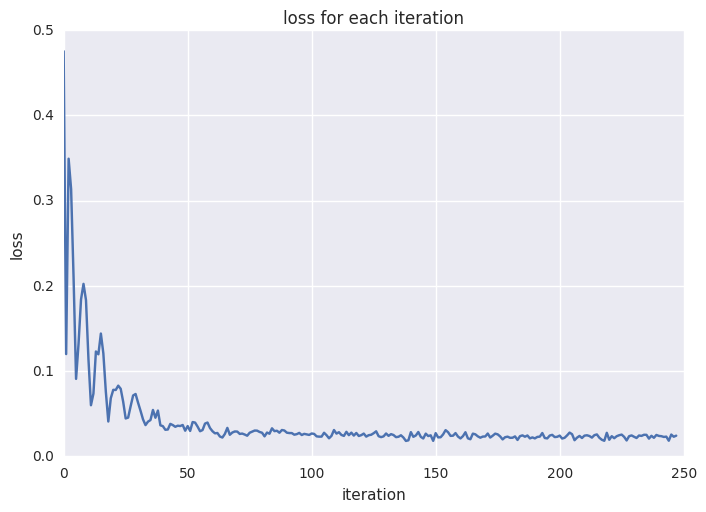

In [9]:
# plot loss
plt.plot(np.sqrt(history))
plt.title("loss for each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")

## Predict

In [10]:
obs = Observer(lstm_size=lstm_size)

sc = []
for ts, df in train_df.groupby('timestamp'):
    pred = obs.predict(df, M, session)
    sc.append(score(df['y'].values, pred[:,0,0]))

average score: -0.381635517484


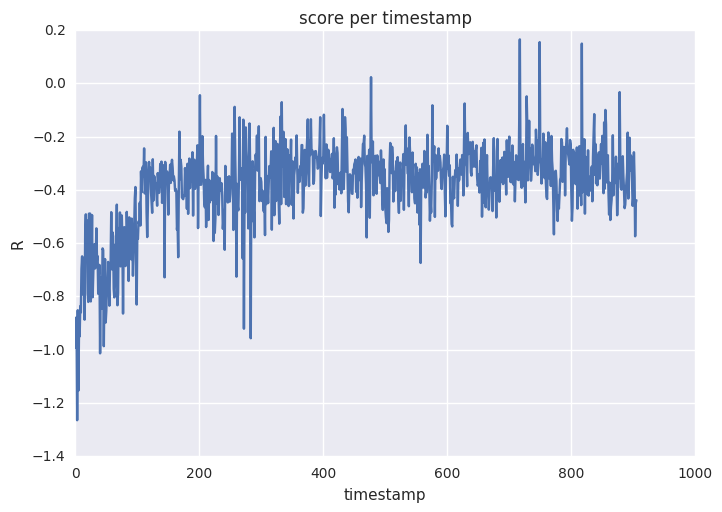

In [11]:
print("average score: {}".format(np.mean(sc)))

# plot score
plt.plot(sc)
plt.title("score per timestamp")
plt.xlabel("timestamp")
plt.ylabel("R")

In [12]:
sample_stream = train_df[train_df['id'] == 10]
ssX = np.expand_dims(sample_stream.drop(['id', 'y'], axis=1), axis=0)
ssy = sample_stream['y'].values
ssL = [len(ssy)]
ssP, _ = M.predict_on_batch(session, ssX, ssL)

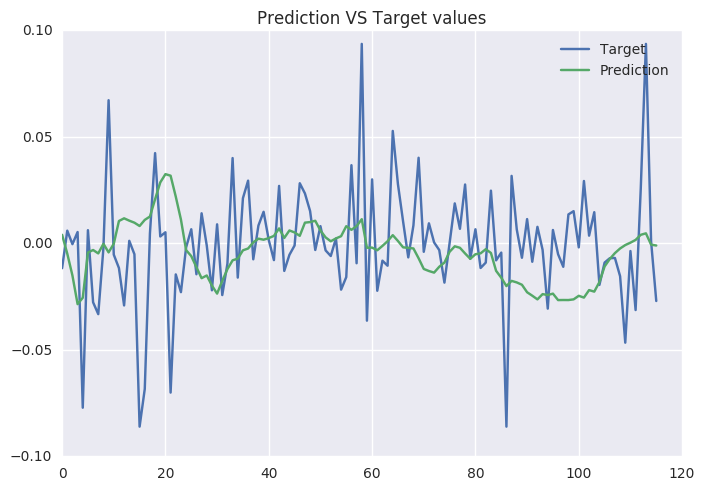

In [13]:
plt.title("Prediction VS Target values")
plt.plot(ssy)
plt.plot(ssP[0,:,0])
plt.legend(['Target', 'Prediction'])